<a href="https://colab.research.google.com/github/erkulev/erk/blob/main/%D0%93%D0%B8%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D1%8B_%D0%B8_%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%80%D0%BA%D0%B0_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Схема использования моделей машинного обучения с учителем.
1. Выбрать класс модели.
2. Выбрать гиперпараметры модели.
3. Обучить модель на данных обучающей последовательности.
4. Использовать модель, чтобы предсказать метки для новых данных

Загрузка данных


In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Выберем  модель KNeighborsClassifier и гиперпараметры n_neighbors=1.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)


Обучим модель

In [ ]:
model.fit(X, y)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

используем ее для предсказания меток для уже известных данных:

In [ ]:
y_model = model.predict(X)


вычисляем долю правильно маркированных точек

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

Зтот подход имеет фундаментальный изъян: обучение и оценка модели выполняются на одних и тех же данных!

Для более точного выяснения рабочих характеристик модели воспользуемся так называемыми отложенными наборами данных (holdout sets)
Это разделение в Scikit-Learn можно произвести с помощью утилиты train_test_split:

In [ ]:
from sklearn.model_selection import train_test_split
# Разделяем данные: по 50% в каждом из наборов
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
train_size=0.5)
# Обучаем модель на одном из наборов данных
model.fit(X1, y1)
# Оцениваем работу модели на другом наборе
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

# Перекрестная проверка (cross-validation)
Потеря части наших данных для обучения модели — один из недостатков использования отложенного набора данных для проверки модели. 
Один из способов решения этой проблемы — перекрестная проверка (cross-validation), то есть выполнение последовательности аппроксимаций, в которых каждое подмножество данных используется как в качестве обучающей последовательности
Мы выполняем две попытки проверки, попеременно используя каждую половину данных в качестве отложенного набора данных. Воспользовавшись полученными выше разделенными данными, мы можем реализовать это следующим образом:

In [ ]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

Этот конкретный вид перекрестной проверки, в которой мы разбили данные на два набора и по очереди использовали каждый из них в качестве проверочного набора, называется двухблочной перекрестной проверкой (two-fold cross-validation).
Можно распространить эту идею на случай большего числа попыток и большего количества блоков данных. Представлена пятиблочная перекрестная проверка.

В этом случае мы разбиваем данные на пять групп и по очереди используем каждую из них для оценки обучения модели на остальных 4/5 данных. Делать это вручную довольно утомительно, так что воспользуемся удобной утилитой cross_val_score библиотеки Scikit-Learn для большей краткости синтаксиса

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

# Выбор оптимальной модели

Что делать, если наш оцениватель показывает недостаточно хорошие результаты? Существует несколько возможных ответов:

1.Использовать более сложную/гибкую модель;

2.Применять менее сложную/гибкую модель;

3.Собрать больше выборок для обучения;

4.Собрать больше данных для добавления новых признаков к каждой заданной выборке.

Иногда использование более сложной модели приводит к худшим результатам, а добавление новых выборок для обучения не приводит к их улучшению! Успешных специалистов-практиков в области машинного обучения как раз и отличает умение определять, какие действия улучшат характеристики модели.

Выбор «оптимальной модели» состоит в поиске наилучшего компромисса между систематической ошибкой (bias) и дисперсией (variance).

# Кривые проверки в библиотеке Scikit-Learn

Рассмотрим пример перекрестной проверки для расчета кривой проверки для класса моделей. Мы будем использовать модель полиномиальной регрессии (polynomial regression model): это обобщенная линейная модель с параметризованной степенью многочлена. Например, многочлен 1-й степени аппроксимирует наши данные прямой линией; при параметрах модели a и b:
y = ax + b.
Многочлен 3-й степени аппроксимирует наши данные кубической кривой; при параметрах модели a, b, c, d:
y = ax3 + bx2 + cx + d.
Это можно обобщить на любое количество полиномиальных признаков
В библиотеке Scikit-Learn реализовать это можно с помощью простой линейной регрессии в сочетании с полиномиальным препроцессором. Мы воспользуемся конвейером (pipeline) для соединения этих операций в единую цепочку

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
        LinearRegression(**kwargs))

Создадим данные, на которых будем обучать нашу модель:

In [ ]:
import numpy as np
def make_data(N, err=1.0, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

Визуализируем наши данные вместе с несколькими аппроксимациями их многочленами различной степени

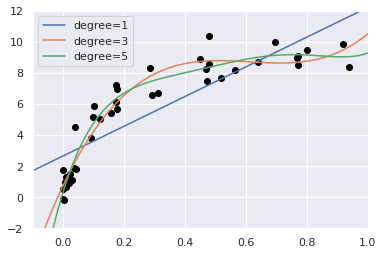

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # plot formatting

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');

Параметром, служащим для управления сложностью модели, в данном случае является степень многочлена, которая может быть любым неотрицательным числом.Какая степень многочлена обеспечивает подходящий компромисс между систематической ошибкой (недообучение) и дисперсией (переобучение)?

Text(0.5, 1.0, 'VСхема проверочной кривой')

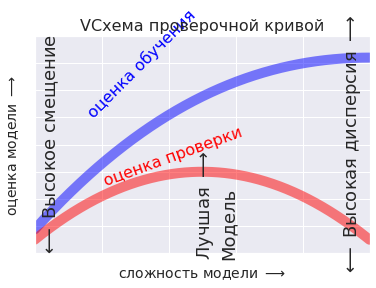

In [ ]:
x = np.linspace(0, 1, 1000)
y1 = -(x - 0.5) ** 2
y2 = y1 - 0.33 + np.exp(x - 1)

fig, ax = plt.subplots()
ax.plot(x, y2, lw=10, alpha=0.5, color='blue')
ax.plot(x, y1, lw=10, alpha=0.5, color='red')

ax.text(0.15, 0.2, "оценка обучения", rotation=45, size=16, color='blue')
ax.text(0.2, -0.05, "оценка проверки", rotation=20, size=16, color='red')

ax.text(0.02, 0.1, r'$\longleftarrow$ Высокое смещение', size=18, rotation=90, va='center')
ax.text(0.98, 0.1, r'$\longleftarrow$ Высокая дисперсия $\longrightarrow$', size=18, rotation=90, ha='right', va='center')
ax.text(0.48, -0.12, 'Лучшая $\\longrightarrow$\nМодель', size=18, rotation=90, va='center')

ax.set_xlim(0, 1)
ax.set_ylim(-0.3, 0.5)

ax.set_xlabel(r'сложность модели $\longrightarrow$', size=14)
ax.set_ylabel(r'оценка модели $\longrightarrow$', size=14)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax.set_title("VСхема проверочной кривой", size=16)

Показанную здесь диаграмму часто называют кривой проверки , и мы видим следующие важные особенности:

1.Оценка обучения везде выше, чем оценка валидации. Обычно это так: модель лучше подходит для данных, которые она видела, чем для данных, которых она не видела.

2.Для очень низкой сложности модели (модель с высоким смещением) обучающие данные не подходят, что означает, что модель является плохим предсказателем как для обучающих данных, так и для любых ранее невидимых данных.

3.Для очень высокой сложности модели (модель с высокой дисперсией) обучающие данные являются избыточными, что означает, что модель очень хорошо предсказывает обучающие данные, но не работает для любых ранее невидимых данных.

4.Для некоторого промежуточного значения кривая валидации имеет максимум. Этот уровень сложности указывает на подходящий компромисс между смещением и дисперсией.

В качестве оценки эффективности здесь используется R2 — коэффициент детерминации или коэффициент смешанной корреляции. Он представляет собой меру того, насколько хорошо модель работает по сравнению с простым средним значением целевых величин. R2 = 1 означает идеальное совпадение предсказаний, а R2 = 0 показывает, что модель оказалась ничем не лучше простого среднего значения данных, а отрицательные значения указывают на модели, которые работают еще хуже.

Чтобы решить этот вопрос, визуализируем кривую проверки для этих конкретных данных и моделей. Проще всего сделать это с помощью предоставляемой библиотекой Scikit-Learn удобной утилиты validation_curve. Эта функция, получив на входе модель, данные, название параметра и диапазон для анализа, автоматически вычисляет в этом диапазоне значение как оценки эффективности для обучения, так и оценки эффективности для проверки

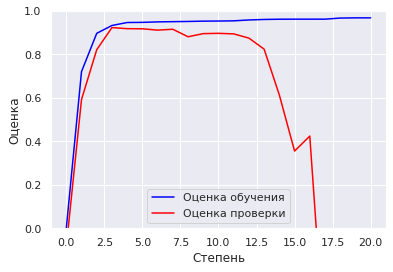

In [ ]:

from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
'polynomialfeatures__degree',
degree, cv=7)
plt.plot(degree, np.median(train_score, 1), color='blue',
label='Оценка обучения') # Оценка обучения
plt.plot(degree, np.median(val_score, 1), color='red',
label='Оценка проверки') # Оценка проверки
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('Степень') # Степень
plt.ylabel('Оценка'); # Оценка

Этот график в точности демонстрирует ожидаемое нами качественное поведение: оценка эффективности для обучения на всем диапазоне превышает оценку эффективности для проверки; оценка эффективности для обучения монотонно растет с ростом сложности модели, а оценка эффективности для проверки достигает максимума перед резким спадом в точке, где модель становится переобученной.

Как можно понять из приведенной кривой проверки, оптимальный компромисс между систематической ошибкой и дисперсией достигается для многочлена третьей степени. Вычислить и отобразить на графике эту аппроксимацию на исходных данных можно следующим образом

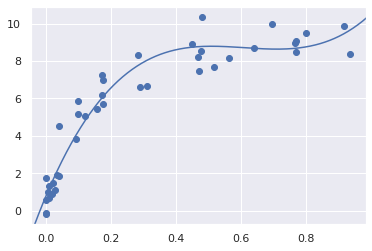

In [ ]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

# Кривые обучения
Важный нюанс сложности моделей состоит в том, что оптимальность модели обычно зависит от размера обучающей последовательности. Например, сгенерируем новый набор данных с количеством точек в пять раз больше

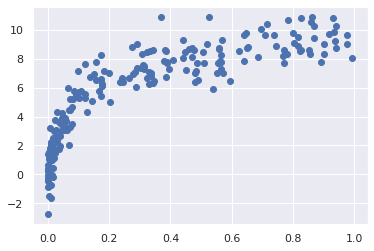

In [ ]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);

Повторим вышеприведенный код для построения графика кривой обучения для этого большего набора данных. Для сравнения выведем поверх и предыдущие результаты

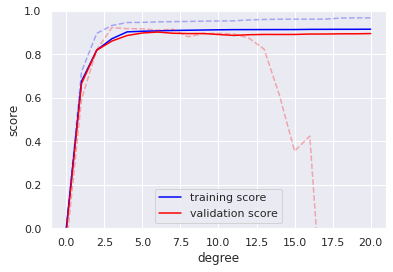

In [ ]:
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
'polynomialfeatures__degree',
degree, cv=7)
plt.plot(degree, np.median(train_score2, 1), color='blue',
label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red',
label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3,
linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3,
linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

Сплошные линии показывают новые результаты, а более бледные штриховые линии — результаты предыдущего меньшего набора данных. Из кривой проверки ясно, что этот больший набор данных позволяет использовать намного более сложную модель: максимум, вероятно, возле степени 6, но даже модель со степенью 20 не выглядит сильно переобученной — оценки эффективности для проверки и обучения остаются очень близки друг к другу.

Таким образом, мы видим, что поведение кривой проверки зависит не от одного, а от двух важных факторов: сложности модели и количества точек обучения. Зачастую бывает полезно исследовать поведение модели как функции от количества точек обучения. Сделать это можно путем использования постепенно увеличивающихся подмножеств данных для обучения модели. График оценок для обучения/проверки с учетом размера обучающей последовательности известен под названием кривой обучения (learning curve).

Поведение кривой обучения должно быть следующим.

1.Модель заданной сложности окажется переобученной на слишком маленьком наборе данных. Это значит, что оценка эффективности для обучения будет относительно высокой, а оценка эффективности для проверки — относительно низкой.

2.Модель заданной сложности окажется недообученной на слишком большом наборе данных. Это значит, что оценка эффективности для обучения будет снижаться, а оценка эффективности для проверки — повышаться по мере роста размера набора данных.

3.Модель никогда, разве что случайно, не покажет на проверочном наборе лучший результат, чем на обучающей последовательности. Это значит, что кривые будут сближаться, но никогда не пересекутся.

Text(0.5, 1.0, 'Схема кривой обучения')

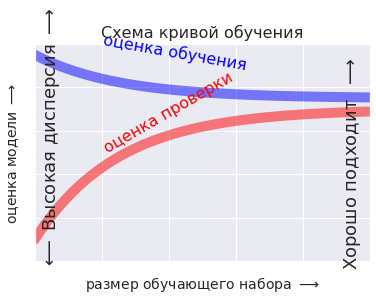

In [ ]:
N = np.linspace(0, 1, 1000)
y1 = 0.75 + 0.2 * np.exp(-4 * N)
y2 = 0.7 - 0.6 * np.exp(-4 * N)

fig, ax = plt.subplots()
ax.plot(x, y1, lw=10, alpha=0.5, color='blue')
ax.plot(x, y2, lw=10, alpha=0.5, color='red')

ax.text(0.2, 0.88, "оценка обучения", rotation=-10, size=16, color='blue')
ax.text(0.2, 0.5, "оценка проверки", rotation=30, size=16, color='red')

ax.text(0.98, 0.45, r'Хорошо подходит  $\longrightarrow$', size=18, rotation=90, ha='right', va='center')
ax.text(0.02, 0.57, r'$\longleftarrow$ Высокая дисперсия $\longrightarrow$', size=18, rotation=90, va='center')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.set_xlabel(r'размер обучающего набора $\longrightarrow$', size=14)
ax.set_ylabel(r'оценка модели $\longrightarrow$', size=14)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax.set_title("Схема кривой обучения", size=16)



Примечательной особенностью кривой обучения является сходимость к определенному баллу по мере роста количества обучающих выборок. В частности, как только у вас будет достаточно точек для схождения конкретной модели, добавление дополнительных обучающих данных вам не поможет! Единственный способ повысить производительность модели в этом случае - использовать другую (часто более сложную) модель.

Кривые обучения в Scikit-Learn 
Scikit-Learn предлагает удобную утилиту для вычисления таких кривых обучения на основе ваших моделей; здесь мы вычислим кривую обучения для нашего исходного набора данных с полиномиальной моделью второго порядка и полиномом девятого порядка:

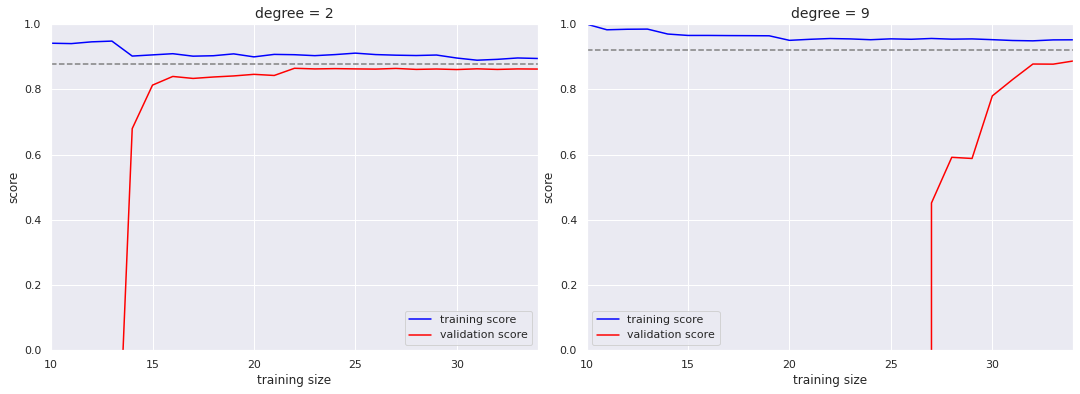

In [ ]:
from sklearn.model_selection import learning_curve

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

Это ценный показатель, поскольку он наглядно демонстрирует нам реакцию нашей модели на увеличение объема обучающих данных. В частности, после того момента, когда кривая обучения уже сошлась к какому-то значению (то есть когда кривые обучения и проверки уже близки друг к другу), добавление дополнительных обучающих данных не улучшит аппроксимацию существенно! Эта ситуация отражена на левом рисунке с кривой обучения для модели второй степени.

Единственный способ улучшения оценки уже сошедшейся кривой — использовать другую (обычно более сложную) модель. Это видно на правом рисунке: перейдя к более сложной модели, мы улучшаем оценку для точки сходимости (отмеченную штриховой линией) за счет более высокой дисперсии модели (соответствующей расстоянию между оценками эффективности для обучения и проверки). Если бы нам пришлось добавить еще больше точек, кривая обучения для более сложной из этих моделей все равно в итоге бы сошлась.

Проверка на практике: поиск по сетке
Из предшествующего обсуждения вы должны были понять смысл компромисса между систематической ошибкой и дисперсией и его зависимость от сложности модели и размера обучающей последовательности. На практике у моделей обычно больше одного параметра, поэтому графики кривых проверки и обучения превращаются из двумерных линий в многомерные поверхности. Выполнение подобных визуализаций в таких случаях представляет собой непростую задачу, поэтому лучше отыскать конкретную модель, при которой оценка эффективности для проверки достигает максимума.

Библиотека Scikit-Learn предоставляет для этой цели специальные автоматические инструменты, содержащиеся в модуле grid_search. Рассмотрим трехмерную сетку признаков модели — степени многочлена, флага, указывающего, нужно ли подбирать точку пересечения с осью координат, и флага, указывающего, следует ли выполнять нормализацию. Выполнить эти настройки можно с помощью мета-оценивателя GridSearchCV библиотеки Scikit-Learn:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'polynomialfeatures__degree': np.arange(21),
              'linearregression__fit_intercept': [True, False],
              'linearregression__normalize': [True, False]}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)
grid.fit(X, y);
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

При необходимости можно воспользоваться этой оптимальной моделью и продемонстрировать аппроксимацию с помощью уже виденного вами выше кода

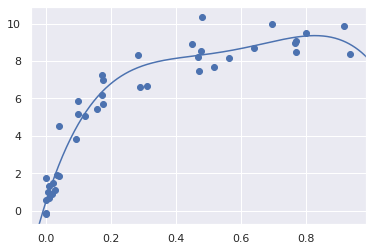

In [ ]:
model = grid.best_estimator_

plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = model.fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

Оптимальная модель, определенная посредством
автоматического поиска по сетке